In [1]:
import pandas as pd
import json 

# Merging speech data with embeddings

In [2]:
filepath = "/Users/f004p74/Documents/dartmouth/projects/MIND2023/blart-podcast/output/"
json_files = ["2015","2016","2017","2018","2019","2020","2021","2022"]

json_dicts = []

for file in json_files:
    with open(filepath+"Blart"+file+".json","r") as read_file:
        whisper_data = json.load(read_file)
    json_dicts.append(whisper_data)

In [3]:
for index,episode_dict in enumerate(json_dicts):
    df = pd.read_csv(filepath+"Blart"+json_files[index]+"_embeddings.csv")
        
    speaker_segment, speaker_id = [], []
        
    for segment in episode_dict:
        speaker_segment.append(segment['text'])
        try:
            speaker_id.append(segment['speaker'])
        except:
            speaker_id.append("UNKNOWN")

    df['segment'] = speaker_segment
    df['speaker'] = speaker_id
    
    df.to_csv(filepath+"Blart"+json_files[index]+"_diarized.csv")

In [4]:
# combining all of the dataframes into a single, large dataset

dataset = []

for file in json_files:
    df = pd.read_csv(filepath+"Blart"+file+"_diarized.csv")
    dataset.append(df)

combined = pd.concat(dataset, axis=0)

combined.to_csv(filepath+'full_dataset.csv')

# Basic text analysis

In [25]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/f004p74/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/f004p74/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/f004p74/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
filepath = "/Users/f004p74/Documents/dartmouth/projects/MIND2023/blart-podcast/output/"
json_files = ["2015","2016","2017","2018","2019","2020","2021","2022"]

df = pd.read_csv(filepath+"full_dataset.csv")

### Sentiment Analysis

In [71]:
analyzer = SentimentIntensityAnalyzer()

In [72]:
def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return sentiment


df['sentiment'] = df['segment'].apply(get_sentiment)

Text(0.5, 1.0, 'Average sentiment across episodes')

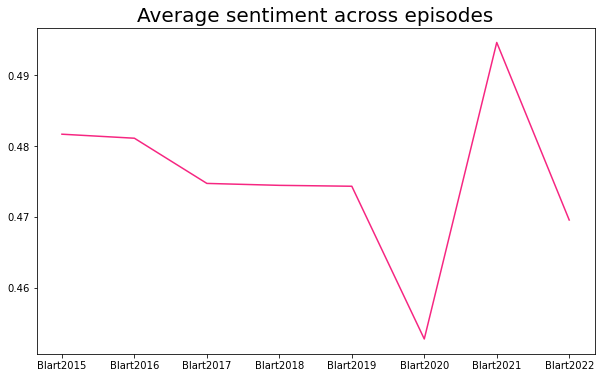

In [91]:
#plot a hist of the average sentiment per episode
x = df.groupby('episode').sentiment.mean()

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(x, color="#f62681")
plt.title('Average sentiment across episodes', size=20)

### Word Frequency

In [99]:
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# apply the function df

df['cleanedSegment'] = df['segment'].apply(preprocess_text)

In [64]:
episode_list = ["Blart2015", "Blart2016", "Blart2017", "Blart2018", "Blart2019", "Blart2020", "Blart2021", "Blart2022"]
episode_frequencies = []
stop_word_frequencies = []

for episode in episode_list:
    word_list = []
    exclude_list = [".",",","!","'","?","'s","n't","'re","'m", "'ve", "'ll","u","'d"]
    
    segments = df.loc[df['episode'] == episode]["cleanedSegment"]
    
    for segment in segments:
        token_list = word_tokenize(segment)
        
        for word in token_list:
            if word not in exclude_list:
                word_list.append(word.lower())
    
    episode_frequencies.append(FreqDist(token for token in word_list).most_common(5))

In [65]:
series_list = []

for word_list in episode_frequencies:
    series_list.append(pd.Series(dict(word_list)))

freq_df = pd.DataFrame(series_list)

Text(0.5, 1.0, 'Word frequencies (5 most common)')

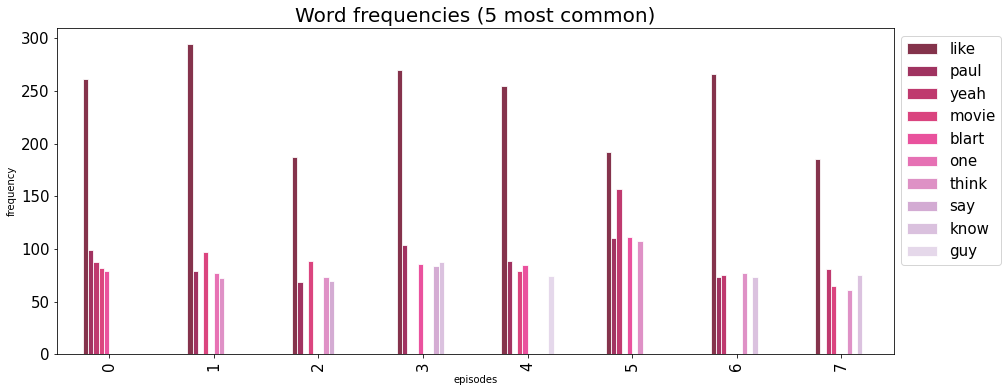

In [132]:
cmap = plt.get_cmap('PuRd_r')
colors = [cmap(i) for i in np.linspace(0, 1, len(stop_df.columns))]

freq_df.plot.bar(figsize=(15,6), fontsize=15, color=colors, alpha=0.8, edgecolor="white",
                 xlabel='episodes',ylabel='frequency')

plt.legend(bbox_to_anchor = (1,1),fontsize=15)
plt.title('Word frequencies (5 most common)', size=20)

### Stop word frequencies

In [20]:
# look at the frequency of stop words across the episodes
episode_list = ["Blart2015", "Blart2016", "Blart2017", "Blart2018", "Blart2019", "Blart2020", "Blart2021", "Blart2022"]
stop_word_frequencies = []

for episode in episode_list:
    word_list = []
    
    segments = df.loc[df['episode'] == episode]["segment"]
    
    for segment in segments:
        token_list = word_tokenize(segment)
    
        for word in token_list:
                    word_list.append(word.lower())
    
    stop_words = [token for token in word_list if token in stopwords.words('english')]
        
    stop_word_frequencies.append(FreqDist(token for token in stop_words).most_common(10))
    

In [21]:
series_list = []

for word_list in stop_word_frequencies:
    series_list.append(pd.Series(dict(word_list)))

stop_df = pd.DataFrame(series_list)

Text(0.5, 1.0, 'Stop Word frequencies (10 most common, not normalized!)')

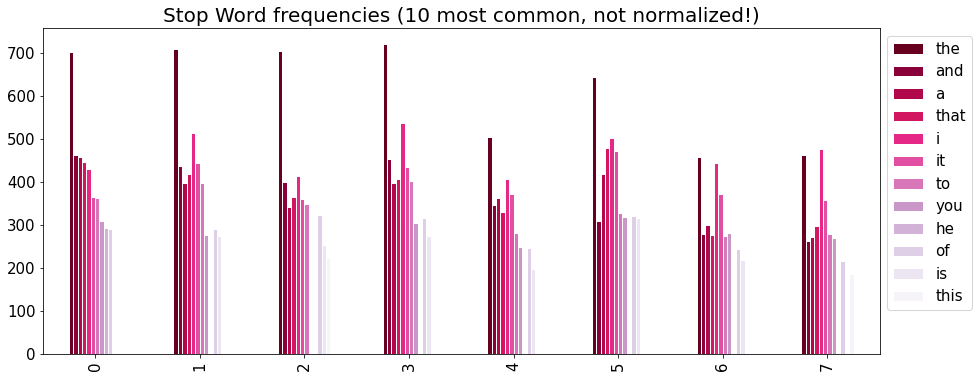

In [133]:
#freq_df[['blart','think','paul','yeah','fucking',"movie"]].plot.bar(figsize=(10,6))
cmap = plt.get_cmap('PuRd_r')
colors = [cmap(i) for i in np.linspace(0, 1, len(stop_df.columns))]

stop_df.plot.bar(figsize=(15,6), color=colors, edgecolor='white', fontsize=15)
plt.legend(bbox_to_anchor = (1,1),fontsize=15)
plt.title('Stop Word frequencies (10 most common, not normalized!)', size=20)

#not normalized yet, divide by total number of words per episode

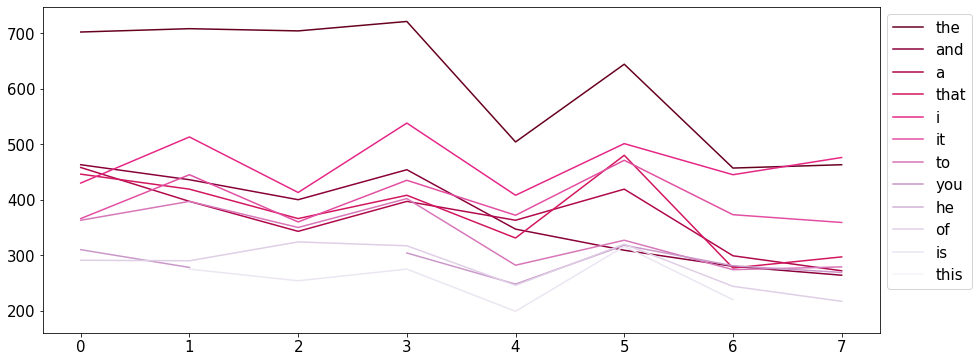

In [51]:
stop_df.plot(figsize=(15,6), color=colors, fontsize=15)
plt.legend(bbox_to_anchor = (1,1), fontsize=15)

# Searching for mental states


In [115]:
states = pd.read_csv("/Users/f004p74/Documents/dartmouth/projects/c-tom-reddit/mental_states.csv")
traits = pd.read_csv("/Users/f004p74/Documents/dartmouth/projects/c-tom-reddit/mental_traits.csv")

state_list = list(states["States"])
trait_list = list(traits["Traits"])

In [110]:
episode_list = ["Blart2015", "Blart2016", "Blart2017", "Blart2018", "Blart2019", "Blart2020", "Blart2021", "Blart2022"]

mental_frequencies = []


for episode in episode_list[0:1]:
    word_list = []
    segments = df.loc[df['episode'] == episode]["cleanedSegment"]
    
    for segment in segments:
        word_list.append(token for token in word_list if token in state_list)
    

0       time begin lifelong adventure , lifelong voyag...
1       're starting mostly stranger , would say , kno...
2                                        hello everyone .
3                             welcome aotearoa , god 's .
4                                  little country could .
                              ...                        
1249                                right pre-nup , boy .
1250    every year snap two side pendant together weav...
1251    griffin , give u famous sign-off line every ep...
1252                                        today , def !
1253    see , work five u still alive record another e...
Name: cleanedSegment, Length: 1254, dtype: object


KeyError: 'cleanedSegments'

# Hypertools

In [136]:
from umap import UMAP
import hypertools as hyp
import pandas as pd
import plotly.express as px
%matplotlib inline

2023-08-14 14:50:06.662111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [137]:
#separate each episode into a list of individual dataframes 
filepath = "/Users/f004p74/Documents/dartmouth/projects/MIND2023/blart-podcast/output/"
json_files = ["2015","2016","2017","2018","2019","2020","2021","2022"]

data_list = []

for file in json_files:
    df = pd.read_csv(filepath+"Blart"+file+"_diarized.csv")
    print(df.shape)
    
    #set all the dfs to the smallest one to ensure sizes are the same
    data_list.append(df.loc[:1012,:"767"])

(1254, 774)
(1137, 774)
(1028, 774)
(1330, 774)
(1012, 774)
(1661, 774)
(1114, 774)
(1067, 774)


In [138]:
arr = hyp.analyze(data_list, normalize='within', reduce='UMAP', ndims=3, internal=False)

In [139]:
# doesn't work second_level = hyp.analyze(arr, normalize='within', reduce=None, align="SRM")

Error in callback <function _reset_backend_notebook.<locals>._deferred_reset_cb at 0x15a36f820> (for pre_run_cell):


ValueError: module://matplotlib_inline.backend_inline is not a valid IPython plotting backend.
Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

<IPython.core.display.Javascript object>


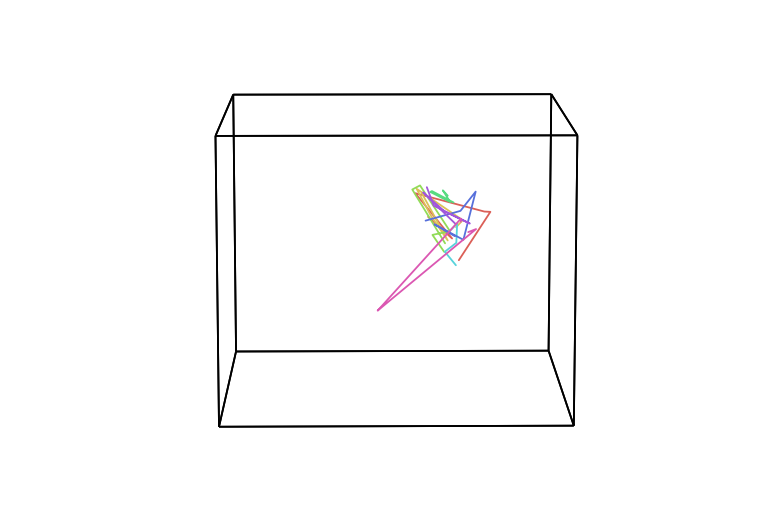

In [150]:
hyp.plot(arr, animate=True, tail_duration=0.1,duration=5,
         save_path='/Users/f004p74/Documents/dartmouth/projects/MIND2023/blart-podcast/figures/video.mov')

# UMAP

In [4]:
dataset = pd.read_csv(filepath+"full_dataset.csv")
features = dataset.loc[:,:"767"]

In [7]:
umap2d = UMAP(n_components=2, n_neighbors=30, init='random',random_state=0, metric='cosine')
umap3d = UMAP(n_components=3, n_neighbors=30, init='random',random_state=0, metric='cosine')

proj_2d = umap2d.fit_transform(features)
proj_3d = umap3d.fit_transform(features)

df3d = pd.DataFrame(proj_3d)

In [8]:
df2d = pd.DataFrame(proj_3d)
df2d[["start","end","episode","segment"]] = dataset[["start","end","episode","segment"]]

fig2d = px.scatter(proj_2d, x=0, y=1, color=df2d.start, labels={'color':'start'})
fig2d.show()

In [9]:
df3d = pd.DataFrame(proj_3d)
df3d[["start","end","episode","segment"]] = dataset[["start","end","episode","segment"]]

In [10]:
fig3d = px.scatter_3d(df3d,x=0,y=1,z=2,color=df3d.start,labels={'color':'episode'},
                      hover_data=["start","end","segment"])
fig3d.update_traces(marker_size=2)
#fig3d.update_layout(hovermode="x unified")
fig3d.show()